<a href="https://colab.research.google.com/github/AnhVietPham/Deep-Learning/blob/main/ResNet_plant_seedlings_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from torch.utils.data import random_split
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
import torchvision.models as models
import cv2
import torchvision
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import copy
import json
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Data-Kaggle/Plant-Seeding/plant-seedlings-classification.zip' -d '/content/plant-seedlings-A-Team'

In [ ]:
def get_num_files(path):
    '''
    Counts the number of files in a folder.
    '''
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [ ]:
dataset_dir = '/content/plant-seedlings-A-Team'
dataset_train_size = get_num_files(os.path.join(dataset_dir, "train"))
dataset_test_size = get_num_files(os.path.join(dataset_dir, "test"))
print('Data samples train size: ', dataset_train_size)
print('Data samples test size: ', dataset_test_size)

Data samples train size:  4750
Data samples test size:  794


In [ ]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

In [ ]:
class RunManager():
    def __init__(self):
        
        self.epoch_count = 0
        self.epoch_start_time = None

        self.epoch_train_loss = 0
        self.epoch_train_num_correct = 0

        self.epoch_valid_loss = 0
        self.epoch_valid_num_correct = 0
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.train_loader = None
        self.valid_loader = None
        self.tb = None
        
    def begin_run(self, run, network, train_loader, valid_loader):
        
        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0   

    def begin_train_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_train_loss = 0
        self.epoch_train_num_correct = 0

    def begin_valid_epoch(self):        
        self.epoch_valid_loss = 0
        self.epoch_valid_num_correct = 0

    def end_epoch(self):
        
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        train_loss = self.epoch_train_loss / len(self.train_loader.dataset)
        train_accuracy = self.epoch_train_num_correct / len(self.train_loader.dataset)

        valid_loss = self.epoch_valid_loss / len(self.valid_loader.dataset)
        valid_accuracy = self.epoch_valid_num_correct / len(self.valid_loader.dataset)
        
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results['train_loss'] = train_loss
        results["train_accuracy"] = train_accuracy
        results['valid_loss'] = valid_loss
        results["valid_accuracy"] = valid_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        
        clear_output(wait=True)
        display(df)
        return valid_accuracy
        
    def track_train_loss(self, loss, batch):
        self.epoch_train_loss += loss.item() * batch[0].shape[0]
        
    def track_train_num_correct(self, preds, labels):
        self.epoch_train_num_correct += self._get_num_correct(preds, labels)

    def track_valid_loss(self, loss, batch):
        self.epoch_valid_loss += loss.item() * batch[0].shape[0]
        
    def track_valid_num_correct(self, preds, labels):
        self.epoch_valid_num_correct += self._get_num_correct(preds, labels)
    
    def _get_num_correct(self, preds, labels):
        pred = preds.data.max(1)[1] # max probability
#         correct += pred.eq(labels.data).cpu().sum()
#         return preds.argmax(dim=1).eq(labels).sum().item()
        return pred.eq(labels.data).cpu().sum().item()

    def save(self, fileName):
        
        pd.DataFrame.from_dict(
            self.run_data
            ,orient='columns'
        ).to_csv(f'./{fileName}.csv')
        
        with open(f'./{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [ ]:
def find_classes(fulldir):
    classes = [d for d in os.listdir(fulldir) if os.path.isdir(os.path.join(fulldir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))
    train = []
    for index, label in enumerate(classes):
        path = fulldir + label + "/"
        for file in os.listdir(path):
            train.append(['{}/{}'.format(label, file), label, index])
    df = pd.DataFrame(train, columns=['files', 'category', 'category_id'])
    return classes, class_to_idx, num_to_class, df

In [ ]:
class SeedingDataset(Dataset):
    def __init__(self, filenames, labels, root_dir, subset=False, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        fullname = os.path.join(self.root_dir, self.filenames.iloc[idx])
        image = Image.open(fullname).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels.iloc[idx]


In [ ]:
from sklearn.model_selection import train_test_split
classes, class_to_idx, num_to_class, df = find_classes(
        '/content/plant-seedlings-A-Team/train/')
X, y = df.drop(['category_id', 'category'], axis=1), df['category_id']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3800, 1)
(3800,)
(950, 1)
(950,)


In [ ]:
from tqdm import tqdm, tqdm_notebook

image_size = (224, 224)
train_dataset = SeedingDataset(
        X_train.files,
        y_train,
        "/content/plant-seedlings-A-Team/train/",
        transform=transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor()
        ]))
valid_dataset = SeedingDataset(
        X_val.files,
        y_val,
        "/content/plant-seedlings-A-Team/train/",
        transform=transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor()
        ]))
means = []
means_sq = []

for img, _ in tqdm_notebook(train_dataset):
    means.append(np.asarray(img, dtype='float32').mean(axis=(1,2)))
    means_sq.append((np.asarray(img, dtype='float32') ** 2).mean(axis=(1,2)))

mean_img = np.mean(means, axis=0)
std_img = np.sqrt(np.mean(means_sq, axis=0) - (mean_img ** 2))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
mean_img, std_img

(array([0.3287954 , 0.2893445 , 0.20746692], dtype=float32),
 array([0.10398009, 0.10943997, 0.12667248], dtype=float32))

In [ ]:
train_dataset = SeedingDataset(
        X_train.files,
        y_train,
        "/content/plant-seedlings-A-Team/train/",
        transform=transforms.Compose([
            transforms.transforms.RandomHorizontalFlip(),
            transforms.transforms.RandomRotation(180),
            transforms.transforms.RandomVerticalFlip(),
            transforms.Resize(size=image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean_img, std_img),
        ]))
valid_dataset = SeedingDataset(
        X_val.files,
        y_val,
        "/content/plant-seedlings-A-Team/train/",
        transform=transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean_img, std_img)
        ]))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=32)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([ 1,  5,  9,  8,  3,  2,  5,  3,  8,  4,  5,  6, 11,  4, 11,  6,  0,  2,
         5,  7,  1, 10,  6, 11, 10,  8,  6,  0, 10,  8,  6, 11])


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)

        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)

        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.dropout = nn.Dropout(0.5)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        out = F.softmax(out, dim = 1)
        return out

In [ ]:
class PreActivationBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActivationBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False))

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
class PreActBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out

In [ ]:
class ReLUOnlyPreActBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(ReLUOnlyPreActBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(x)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn1(out)))
        out = self.conv3(F.relu(self.bn2(out)))
        out = self.bn3(out)
        out += shortcut
        return out

In [ ]:
class ReLUBeforeAdditionBottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
      super(ReLUBeforeAdditionBottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(planes)
      self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)

      self.shortcut = nn.Sequential()
      if stride != 1 or in_planes != self.expansion*planes:
          self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(self.expansion*planes)
          )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = F.relu(self.bn2(self.conv2(out)))
      out = F.relu(self.bn3(self.conv3(out)))
      out += self.shortcut(x)
      return out

In [ ]:
class PreActivationResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActivationResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        out = F.softmax(out, dim = 1)
        return out

In [ ]:
def PreActiVationResNet18(num_classes):
    return PreActivationResNet(PreActivationBasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def PreActiVationResNet152(num_classes):
    return PreActivationResNet(PreActivationBottleneck, [3, 8, 36, 3], num_classes=num_classes)

def PreActiVationResNet176(num_classes):
    return PreActivationResNet(PreActivationBottleneck, [3, 16, 36, 3], num_classes=num_classes)

def PreActiVationResNet201(num_classes):
    return PreActivationResNet(PreActivationBottleneck, [12, 16, 36, 3], num_classes=num_classes)

def ReLuOnLyPreResNet201(num_classes):
  return PreActivationResNet(ReLUOnlyPreActBottleneck, [12, 16, 36, 3],num_classes=num_classes)

def ReLUBeforeAdditionResNet201(num_classes):
  return PreActivationResNet(ReLUBeforeAdditionBottleneck, [12, 16, 36, 3],num_classes=num_classes)

In [ ]:
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

def ResNet101(num_classes):
    return ResNet(Bottleneck, [3, 4, 23, 3],num_classes=num_classes)

def ResNet152(num_classes):
    return ResNet(Bottleneck, [3, 8, 36, 3],num_classes=num_classes)

def ResNet176(num_classes):
    return ResNet(Bottleneck, [3, 16, 36, 3],num_classes=num_classes)

def ResNet201(num_classes):
    return ResNet(Bottleneck, [12, 16, 36, 3],num_classes=num_classes)

In [ ]:
resnet18 = ResNet18(12)

In [ ]:
resnet34 = ResNet34(12)

In [ ]:
resnet50 = ResNet50(12)

In [ ]:
resnet101 = ResNet101(12)

In [ ]:
resnet152 = ResNet152(12)

In [ ]:
resnet176 = ResNet176(12)

In [ ]:
resnet201 = ResNet201(12)

In [ ]:
preresnet176 = PreResNet176(12)

In [ ]:
preresnet152 = PreResNet152(12)

In [ ]:
model_conv = models.resnet34(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 12),
        nn.Softmax(dim=1)
    )

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
train_dataloaders = {
    'normalization': train_loader
}
valid_dataloaders = {
    'normalization': valid_loader
}
networks = {
    'have_dropout': model_conv
}

In [ ]:
params = OrderedDict(
    lr = [1e-3],
    momentum = [0.9],
    batch_size = [16],
    num_workers = [1],
    device = ['cuda'],
    dataloaders = ['normalization'],
    network = list(networks.keys())
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
m = RunManager()
best_acc = 0.0
for run in RunBuilder.get_runs(params):
  network = networks[run.network].to(device)

  train_loader = train_dataloaders[run.dataloaders]
  valid_loader = valid_dataloaders[run.dataloaders]
  
  best_model_wts = copy.deepcopy(network.state_dict())

  optimizer = optim.SGD(network.parameters(), lr= run.lr, momentum= run.momentum)

  m.begin_run(run, network, train_loader, valid_loader)
  for epoch in range(100):
    m.begin_train_epoch()
    network.train()
    for batch in train_loader:
      images = batch[0].to(device)
      labels = batch[1].to(device)
      preds = network(images)
      loss = F.cross_entropy(preds, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      m.track_train_loss(loss, batch)
      m.track_train_num_correct(preds, labels)
    m.begin_valid_epoch()
    network.eval()
    for batch in valid_loader:
      images = batch[0].to(device)
      labels = batch[1].to(device)
      preds = network(images)
      loss = F.cross_entropy(preds, labels)
      m.track_valid_loss(loss, batch)
      m.track_valid_num_correct(preds, labels)
    epoch_acc = m.end_epoch()
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(network.state_dict())
      torch.save({
            'network': run.network,
            'epoch': epoch,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc}, f'./best_model_resnet34_pretrained_have_dropout_normalize_from_scratch_wts.pth')

  m.end_run()
m.save('results_resnet34_pretrained_have_dropout_normalize_from_scratch')

run  epoch  train_loss  ...  device    dataloaders       network
0     1      1    2.437939  ...    cuda  normalization  have_dropout
1     1      2    2.285114  ...    cuda  normalization  have_dropout
2     1      3    2.137260  ...    cuda  normalization  have_dropout
3     1      4    2.051792  ...    cuda  normalization  have_dropout
4     1      5    2.014969  ...    cuda  normalization  have_dropout
..  ...    ...         ...  ...     ...            ...           ...
95    1     96    1.680435  ...    cuda  normalization  have_dropout
96    1     97    1.680341  ...    cuda  normalization  have_dropout
97    1     98    1.678806  ...    cuda  normalization  have_dropout
98    1     99    1.679115  ...    cuda  normalization  have_dropout
99    1    100    1.679398  ...    cuda  normalization  have_dropout

[100 rows x 15 columns]

In [ ]:
model_test.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
data_dir = '/content/plant-seedlings-A-Team/'
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

image_size = (224, 224)
test_trans = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean_img, std_img)
])

kaggle_train_set = SeedingDataset(
    sample_submission.file,
    sample_submission.species,
    '/content/plant-seedlings-A-Team/test/',
    transform=test_trans)

kaggle_test_loader = DataLoader(kaggle_train_set, batch_size=8, shuffle=False, num_workers=0)

def predict(sample_submission, kaggle_test_loader, model):
    predictions = []
    for data, _ in kaggle_test_loader:
        data = data.to(device)
        output = model(data.to(device))
        pred = output.data.max(1)[1] # get the index of the max log-probability
        predictions.extend(pred.tolist())
            

    df_predictions = pd.DataFrame.from_dict({
        'file': sample_submission.file,
        'species': [num_to_class[p] for p in predictions]
    })
    return df_predictions

In [ ]:
from google.colab import files
import io
from google.colab import data_table
import matplotlib.pyplot as plt

In [ ]:
resnet18_file_log = files.upload()

Saving results_resnet18_have_dropout_normalize_from_scratch.csv to results_resnet18_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet34_file_log = files.upload()

Saving results_resnet34_have_dropout_normalize_from_scratch.csv to results_resnet34_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet50_file_log = files.upload()

Saving results_resnet50_have_dropout_normalize_from_scratch.csv to results_resnet50_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet101_file_log = files.upload()

Saving results_resnet101_have_dropout_normalize_from_scratch.csv to results_resnet101_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet152_file_log = files.upload()

Saving results_resnet152_uniform_have_dropout_normalize_from_scratch.csv to results_resnet152_uniform_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet176_file_log = files.upload()

Saving results_resnet176_have_dropout_normalize_from_scratch.csv to results_resnet176_have_dropout_normalize_from_scratch.csv


In [ ]:
original_resnet201_file_log = files.upload()

Saving results_resnet201_have_dropout_normalize_from_scratch.csv to results_resnet201_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet18_df = pd.read_csv(io.BytesIO(resnet18_file_log['results_resnet18_have_dropout_normalize_from_scratch.csv']))
resnet34_df = pd.read_csv(io.BytesIO(resnet34_file_log['results_resnet34_have_dropout_normalize_from_scratch.csv']))
resnet50_df = pd.read_csv(io.BytesIO(resnet50_file_log['results_resnet50_have_dropout_normalize_from_scratch.csv']))
resnet101_df = pd.read_csv(io.BytesIO(resnet101_file_log['results_resnet101_have_dropout_normalize_from_scratch.csv']))
resnet152_df = pd.read_csv(io.BytesIO(resnet152_file_log['results_resnet152_uniform_have_dropout_normalize_from_scratch.csv']))
resnet176_df = pd.read_csv(io.BytesIO(resnet176_file_log['results_resnet176_have_dropout_normalize_from_scratch.csv']))
original_resnet201_df = pd.read_csv(io.BytesIO(original_resnet201_file_log['results_resnet201_have_dropout_normalize_from_scratch.csv']))

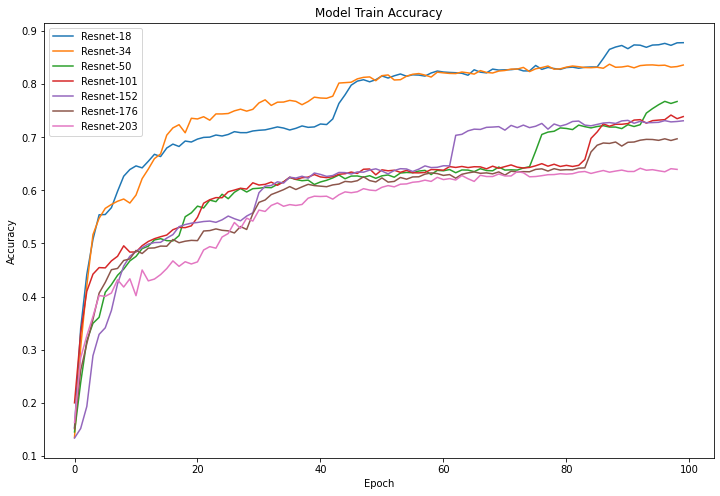

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet18_df["train_accuracy"])
plt.plot(resnet34_df["train_accuracy"])
plt.plot(resnet176_df["train_accuracy"].iloc[0:99])
plt.plot(resnet101_df["train_accuracy"])
plt.plot(resnet50_df["train_accuracy"])
plt.plot(resnet152_df["train_accuracy"].iloc[0:99])
plt.plot(original_resnet201_df["train_accuracy"].iloc[0:99])
plt.title("Model Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-18', 'Resnet-34', 'Resnet-50', 'Resnet-101','Resnet-152', 'Resnet-176', 'Resnet-203'], loc='upper left')
plt.show()

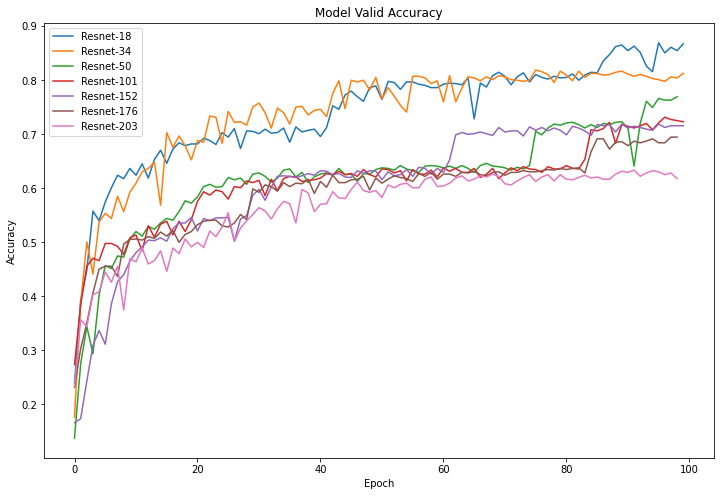

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet18_df["valid_accuracy"])
plt.plot(resnet34_df["valid_accuracy"])
plt.plot(resnet176_df["valid_accuracy"].iloc[0:99])
plt.plot(resnet101_df["valid_accuracy"])
plt.plot(resnet50_df["valid_accuracy"])
plt.plot(resnet152_df["valid_accuracy"].iloc[0:99])
plt.plot(original_resnet201_df["valid_accuracy"].iloc[0:99])
plt.title("Model Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-18', 'Resnet-34', 'Resnet-50', 'Resnet-101','Resnet-152', 'Resnet-176', 'Resnet-203'], loc='upper left')
plt.show()

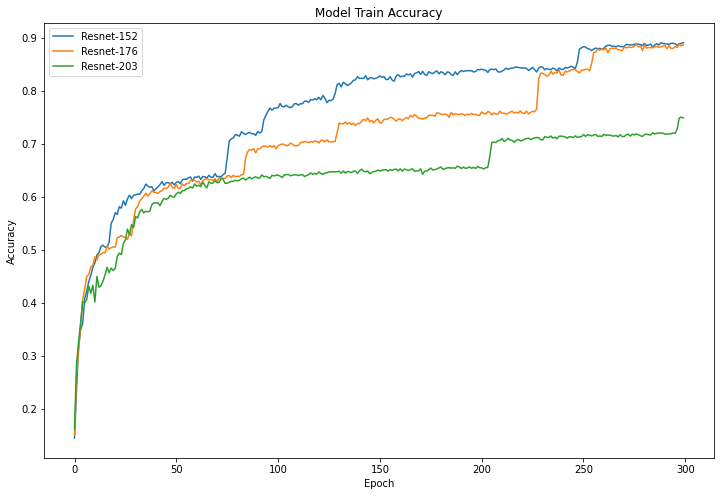

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet176_df["train_accuracy"])
plt.plot(resnet152_df["train_accuracy"])
plt.plot(original_resnet201_df["train_accuracy"])
plt.title("Model Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-152', 'Resnet-176', 'Resnet-203'], loc='upper left')
plt.show()

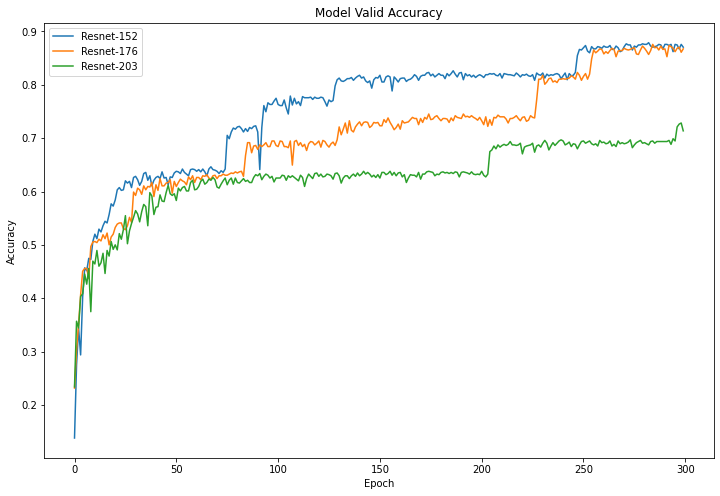

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet176_df["valid_accuracy"])
plt.plot(resnet152_df["valid_accuracy"])
plt.plot(original_resnet201_df["valid_accuracy"])
plt.title("Model Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-152', 'Resnet-176', 'Resnet-203'], loc='upper left')
plt.show()

In [ ]:
resnet18_pretrained_file_log = files.upload()

Saving results_resnet18_pretrained_have_dropout_normalize_from_scratch.csv to results_resnet18_pretrained_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet34_pretrained_file_log = files.upload()

Saving results_resnet34_pretrained_have_dropout_normalize_from_scratch.csv to results_resnet34_pretrained_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet50_pretrained_file_log = files.upload()

Saving results_model_resnet50_pretrained.csv to results_model_resnet50_pretrained.csv


In [ ]:
resnet101_pretrained_file_log = files.upload()

Saving results_model_resnet101_pretrained.csv to results_model_resnet101_pretrained.csv


In [ ]:
resnet152_pretrained_file_log = files.upload()

Saving results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv to results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv


In [ ]:
resnet18_pretrained_df = pd.read_csv(io.BytesIO(resnet18_pretrained_file_log['results_resnet18_pretrained_have_dropout_normalize_from_scratch.csv']))
resnet34_pretrained_df = pd.read_csv(io.BytesIO(resnet34_pretrained_file_log['results_resnet34_pretrained_have_dropout_normalize_from_scratch.csv']))
resnet50_pretrained_df = pd.read_csv(io.BytesIO(resnet50_pretrained_file_log['results_model_resnet50_pretrained.csv']))
resnet101_pretrained_df = pd.read_csv(io.BytesIO(resnet101_pretrained_file_log['results_model_resnet101_pretrained.csv']))
resnet152_pretrained_df = pd.read_csv(io.BytesIO(resnet152_pretrained_file_log['results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv']))

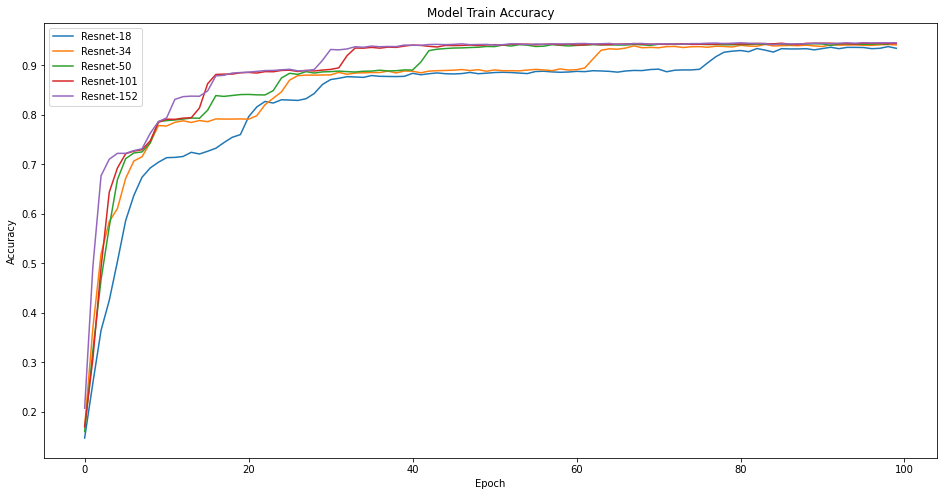

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(resnet18_pretrained_df["train_accuracy"])
plt.plot(resnet34_pretrained_df["train_accuracy"])
plt.plot(resnet50_pretrained_df["train_accuracy"].iloc[0:99])
plt.plot(resnet101_pretrained_df["train_accuracy"])
plt.plot(resnet152_pretrained_df["train_accuracy"])
plt.title("Model Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-18', 'Resnet-34', 'Resnet-50', 'Resnet-101','Resnet-152'], loc='upper left')
plt.show()

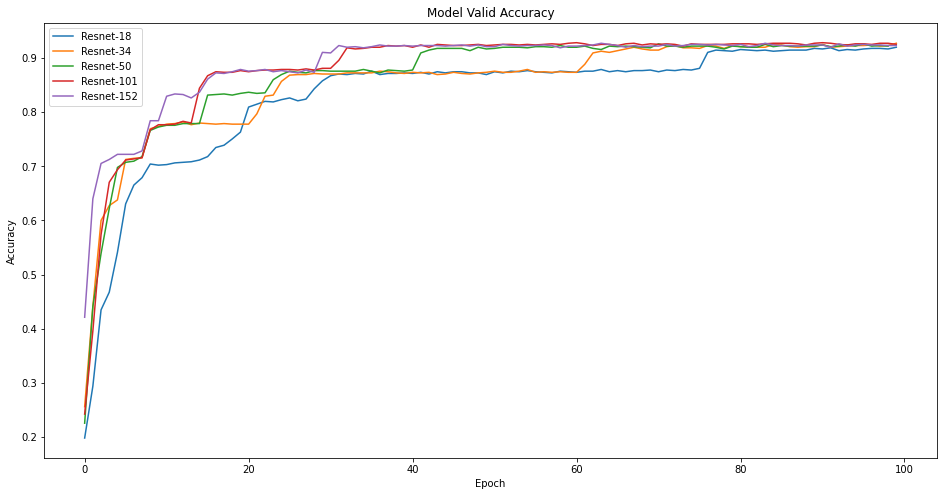

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(resnet18_pretrained_df["valid_accuracy"])
plt.plot(resnet34_pretrained_df["valid_accuracy"])
plt.plot(resnet50_pretrained_df["valid_accuracy"].iloc[0:99])
plt.plot(resnet101_pretrained_df["valid_accuracy"])
plt.plot(resnet152_pretrained_df["valid_accuracy"])
plt.title("Model Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Resnet-18', 'Resnet-34', 'Resnet-50', 'Resnet-101','Resnet-152'], loc='upper left')
plt.show()

In [ ]:
resnet203_results_relu_before_addition_file_log = files.upload()

Saving results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv to results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet203_results_bnafteraddition_scratch_file_log = files.upload()

Saving results_bnafteradditionresnet201_scratch.csv to results_bnafteradditionresnet201_scratch.csv


In [ ]:
resnet203_results_reluonly_scratch_file_log = files.upload()

Saving results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv to results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet203_results_original_scratch_file_log = files.upload()

Saving results_resnet201_have_dropout_normalize_from_scratch.csv to results_resnet201_have_dropout_normalize_from_scratch (1).csv


In [ ]:
resnet203_results_preactivation_scratch_file_log = files.upload()

Saving results_preFullActiVationResNet203_scratch.csv to results_preFullActiVationResNet203_scratch.csv


In [ ]:
resnet203_results_relu_before_addition_df = pd.read_csv(io.BytesIO(resnet203_results_relu_before_addition_file_log['results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv']))
resnet203_results_bnafteraddition_df = pd.read_csv(io.BytesIO(resnet203_results_bnafteraddition_scratch_file_log['results_bnafteradditionresnet201_scratch.csv']))
resnet203_results_reluonly_df = pd.read_csv(io.BytesIO(resnet203_results_reluonly_scratch_file_log['results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv']))
resnet203_results_original_scratch_df = pd.read_csv(io.BytesIO(resnet203_results_original_scratch_file_log['results_resnet201_have_dropout_normalize_from_scratch.csv']))
resnet203_results_preactivation_df = pd.read_csv(io.BytesIO(resnet203_results_preactivation_scratch_file_log['results_preFullActiVationResNet203_scratch.csv']))

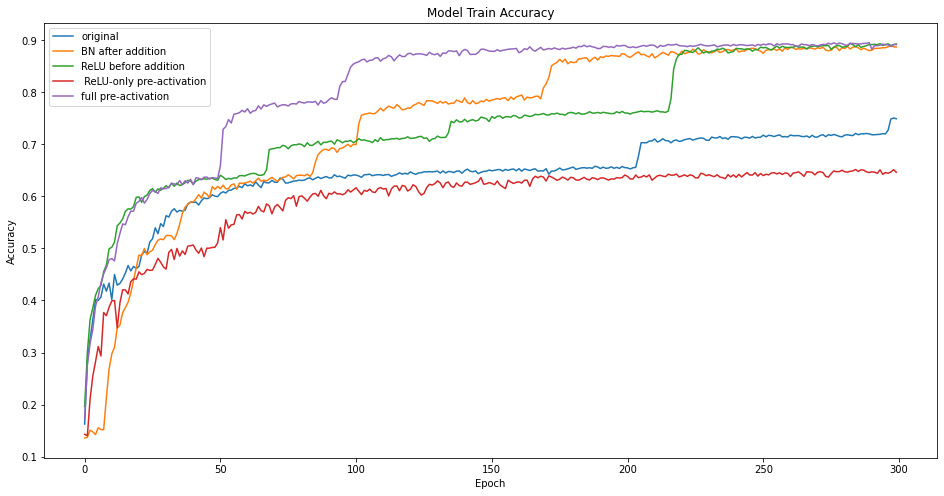

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(resnet203_results_original_scratch_df["train_accuracy"])
plt.plot(resnet203_results_bnafteraddition_df["train_accuracy"])
plt.plot(resnet203_results_relu_before_addition_df["train_accuracy"])
plt.plot(resnet203_results_reluonly_df["train_accuracy"])
plt.plot(resnet203_results_preactivation_df["train_accuracy"])
plt.title("Model Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['original', 'BN after addition', 'ReLU before addition', ' ReLU-only pre-activation', "full pre-activation"], loc='upper left')
plt.show()

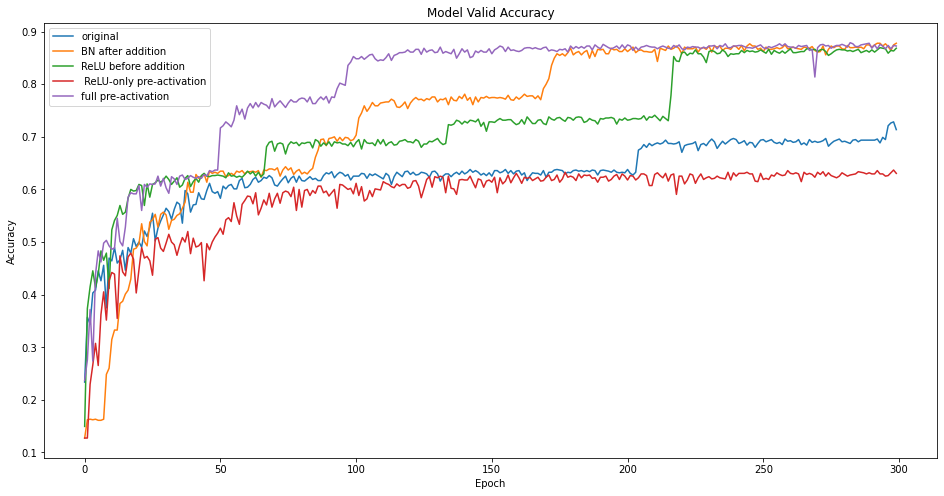

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(resnet203_results_original_scratch_df["valid_accuracy"])
plt.plot(resnet203_results_bnafteraddition_df["valid_accuracy"])
plt.plot(resnet203_results_relu_before_addition_df["valid_accuracy"])
plt.plot(resnet203_results_reluonly_df["valid_accuracy"])
plt.plot(resnet203_results_preactivation_df["valid_accuracy"])
plt.title("Model Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['original', 'BN after addition', 'ReLU before addition', ' ReLU-only pre-activation', "full pre-activation"], loc='upper left')
plt.show()

# **ResNet18**

In [ ]:
resnet18_df = pd.read_csv(io.BytesIO(resnet18_file_log['results_resnet18_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet18_df, include_index=True, num_rows_per_page=20)

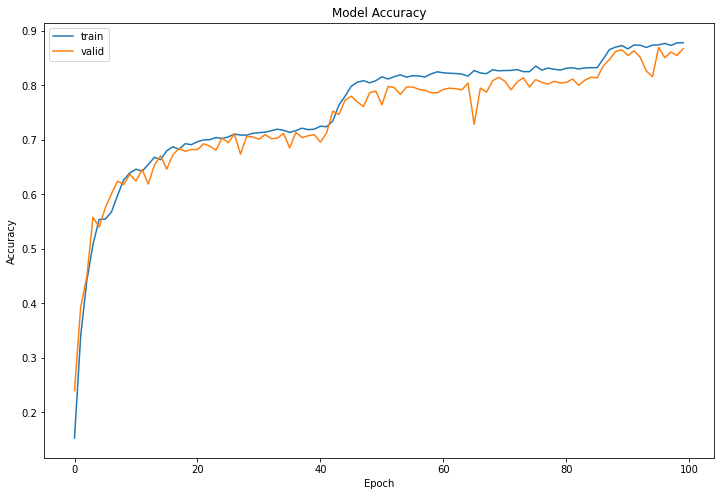

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet18_df["train_accuracy"])
plt.plot(resnet18_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

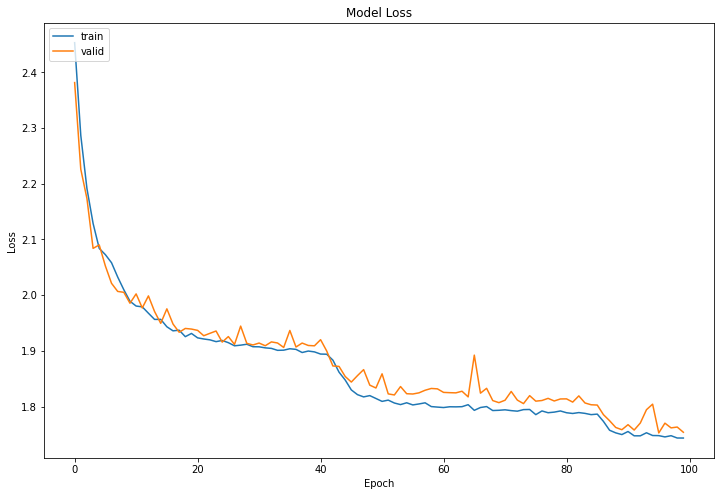

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet18_df["train_loss"])
plt.plot(resnet18_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet34**

In [ ]:
resnet34_file_log = files.upload()

Saving results_resnet34_have_dropout_normalize_from_scratch.csv to results_resnet34_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet34_df = pd.read_csv(io.BytesIO(resnet34_file_log['results_resnet34_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet34_df, include_index=True, num_rows_per_page=20)

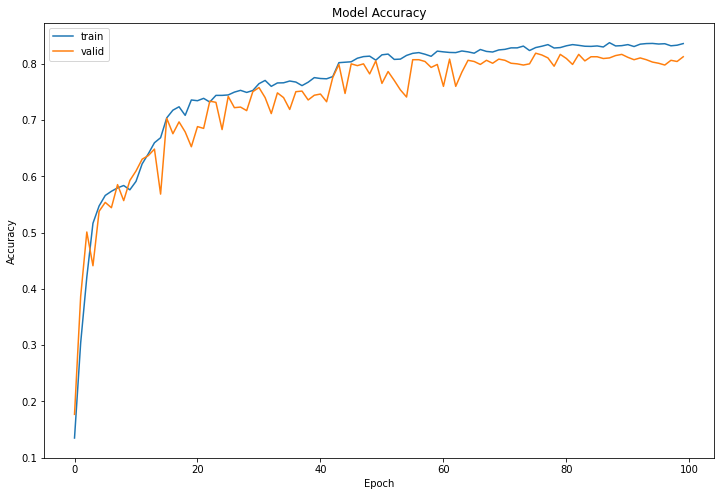

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet34_df["train_accuracy"])
plt.plot(resnet34_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

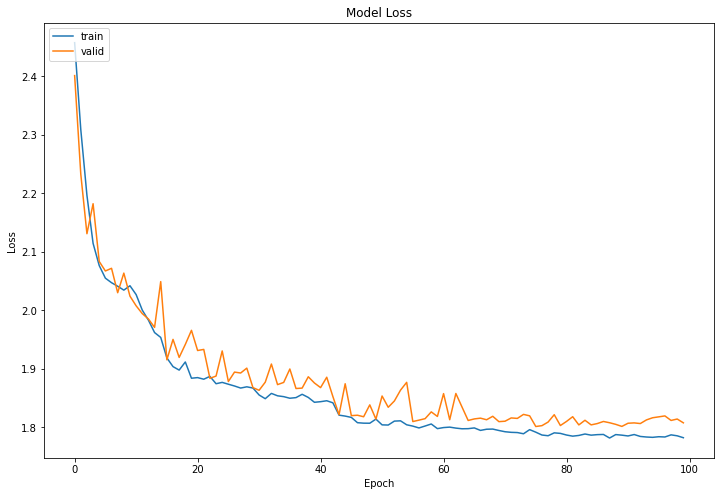

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet34_df["train_loss"])
plt.plot(resnet34_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet50**

**1/ From-Scratch-Random-weight**

In [ ]:
resnet50_file_log = files.upload()

Saving results_resnet50_have_dropout_normalize_from_scratch.csv to results_resnet50_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet50_df = pd.read_csv(io.BytesIO(resnet50_file_log['results_resnet50_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet50_df, include_index=True, num_rows_per_page=20)

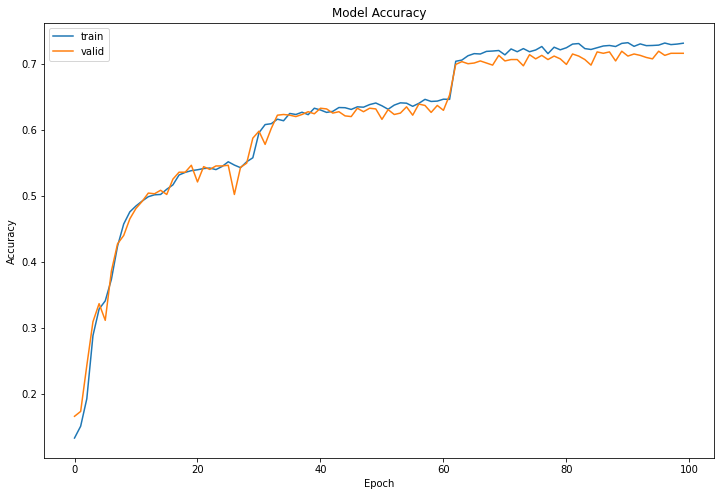

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_accuracy"])
plt.plot(resnet50_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

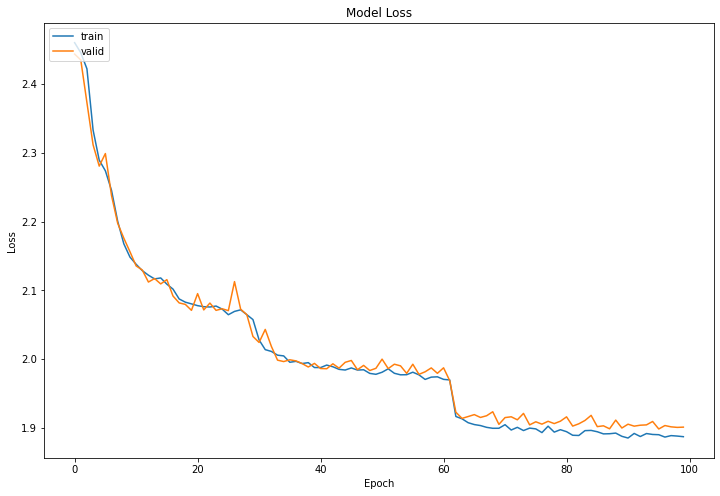

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_loss"])
plt.plot(resnet50_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**2/ From-Torchmodels-Random-weight**

In [ ]:
resnet50_file_log = files.upload()

Saving results_resnet50_have_dropout_normalize_from_torch_models.csv to results_resnet50_have_dropout_normalize_from_torch_models.csv


In [ ]:
resnet50_df = pd.read_csv(io.BytesIO(resnet50_file_log['results_resnet50_have_dropout_normalize_from_torch_models.csv']))
data_table.DataTable(resnet50_df, include_index=True, num_rows_per_page=20)

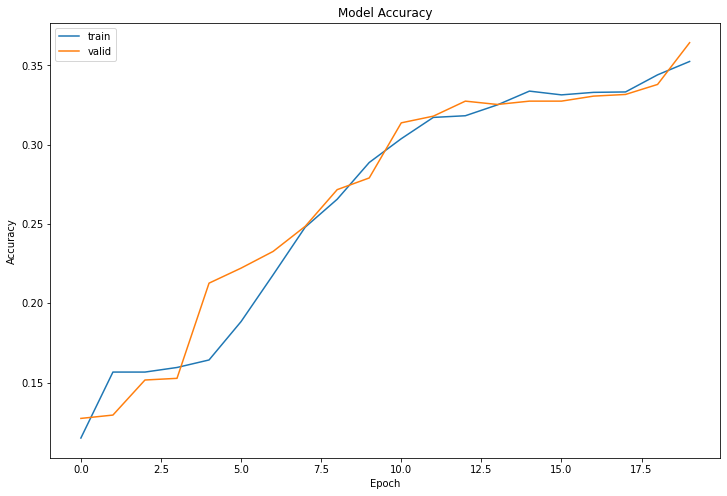

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_accuracy"])
plt.plot(resnet50_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

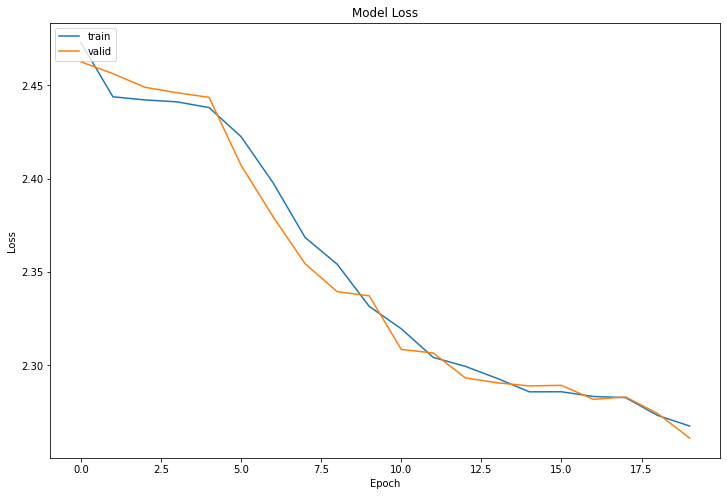

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_loss"])
plt.plot(resnet50_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**3/ From-TorchModels-Pretrained-ImageNet**

In [ ]:
resnet50_file_log = files.upload()

Saving results_resnet50_pretrained_have_dropout_normalize_from_torch_models.csv to results_resnet50_pretrained_have_dropout_normalize_from_torch_models.csv


In [ ]:
resnet50_df = pd.read_csv(io.BytesIO(resnet50_file_log['results_resnet50_pretrained_have_dropout_normalize_from_torch_models.csv']))
data_table.DataTable(resnet50_df, include_index=True, num_rows_per_page=20)

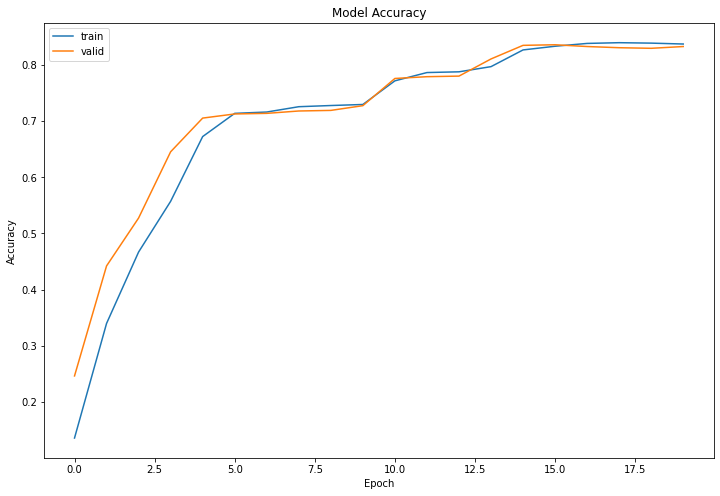

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_accuracy"])
plt.plot(resnet50_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

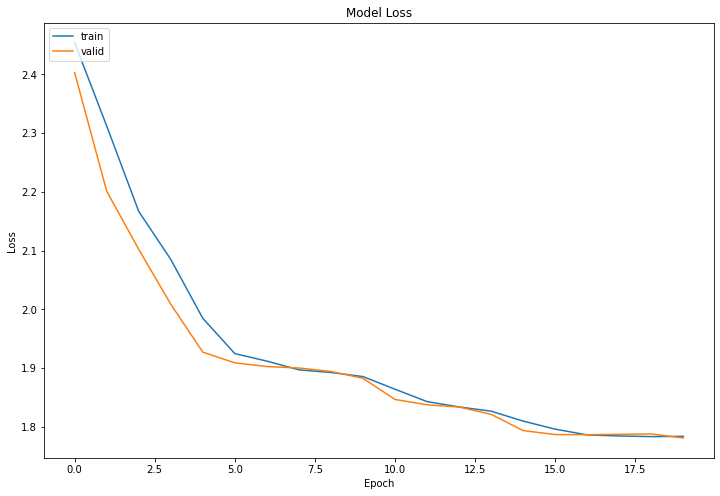

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet50_df["train_loss"])
plt.plot(resnet50_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet101**

**1/ Build-from-scratch**

In [ ]:
resnet101_file_log = files.upload()

Saving results_resnet101_have_dropout_normalize_from_scratch.csv to results_resnet101_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet101_df = pd.read_csv(io.BytesIO(resnet101_file_log['results_resnet101_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet101_df, include_index=True, num_rows_per_page=20)

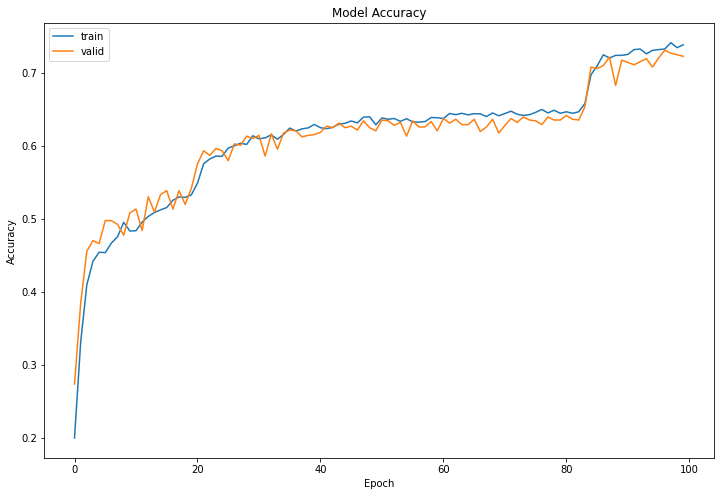

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet101_df["train_accuracy"])
plt.plot(resnet101_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

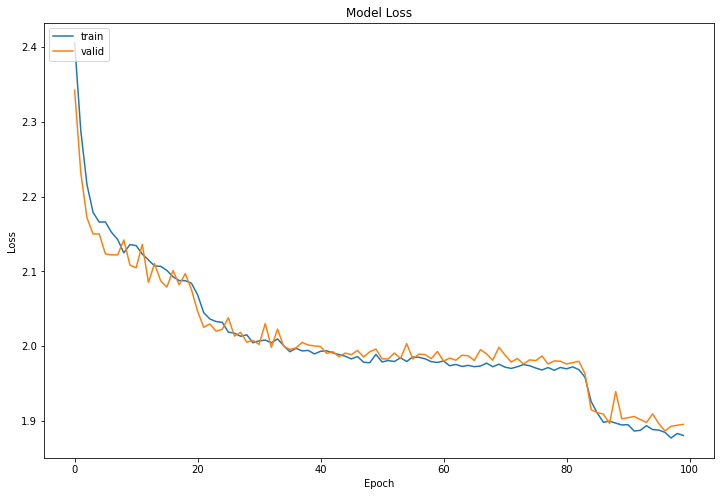

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet101_df["train_loss"])
plt.plot(resnet101_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**1/ Pretrain**

In [ ]:
resnet101_file_log = files.upload()

Saving results_resnet101_pretrained_have_dropout_normalize_from_torch_models.csv to results_resnet101_pretrained_have_dropout_normalize_from_torch_models.csv


In [ ]:
resnet101_df = pd.read_csv(io.BytesIO(resnet101_file_log['results_resnet101_pretrained_have_dropout_normalize_from_torch_models.csv']))
data_table.DataTable(resnet101_df, include_index=True, num_rows_per_page=20)

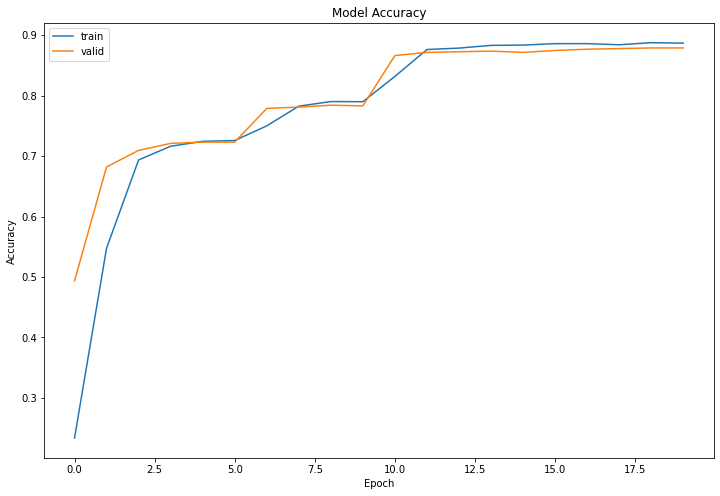

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet101_df["train_accuracy"])
plt.plot(resnet101_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

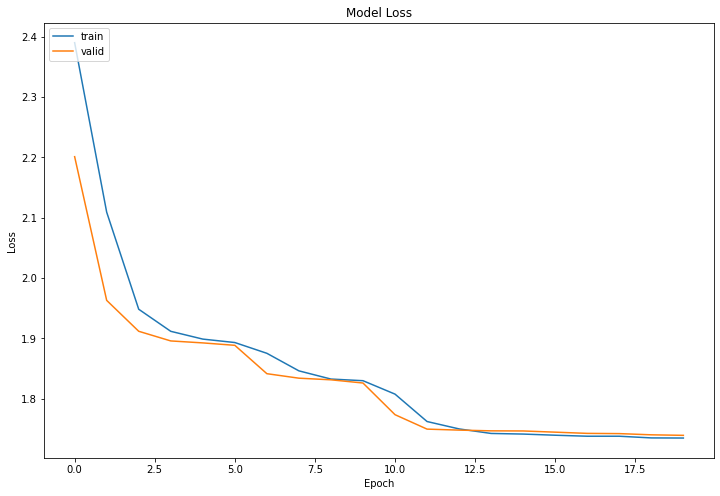

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet101_df["train_loss"])
plt.plot(resnet101_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet152**

**1/ From Scratch**

In [ ]:
resnet152_file_log = files.upload()

Saving results_resnet152_uniform_have_dropout_normalize_from_scratch.csv to results_resnet152_uniform_have_dropout_normalize_from_scratch.csv


In [ ]:
resnet152_df = pd.read_csv(io.BytesIO(resnet152_file_log['results_resnet152_uniform_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet152_df, include_index=True, num_rows_per_page=20)

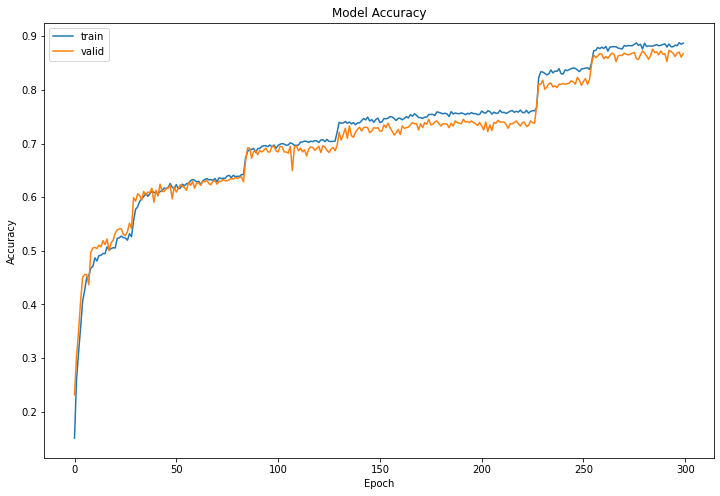

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet152_df["train_accuracy"])
plt.plot(resnet152_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

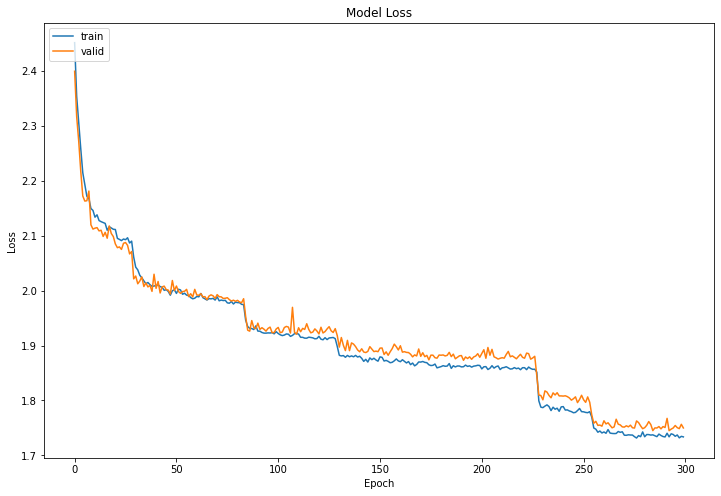

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet152_df["train_loss"])
plt.plot(resnet152_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**2/ Pretrained**

In [ ]:
resnet152_file_log = files.upload()

Saving results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv to results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv


In [ ]:
resnet152_df = pd.read_csv(io.BytesIO(resnet152_file_log['results_resnet152_pretrained_have_dropout_normalize_from_torch_models.csv']))
data_table.DataTable(resnet152_df, include_index=True, num_rows_per_page=20)

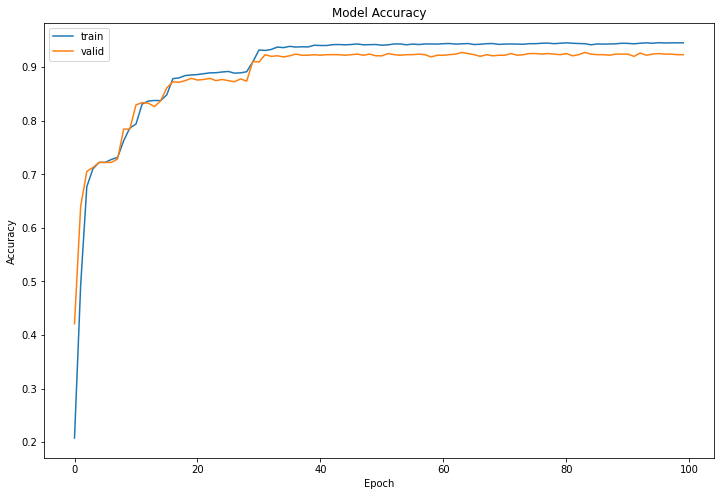

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet152_df["train_accuracy"])
plt.plot(resnet152_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

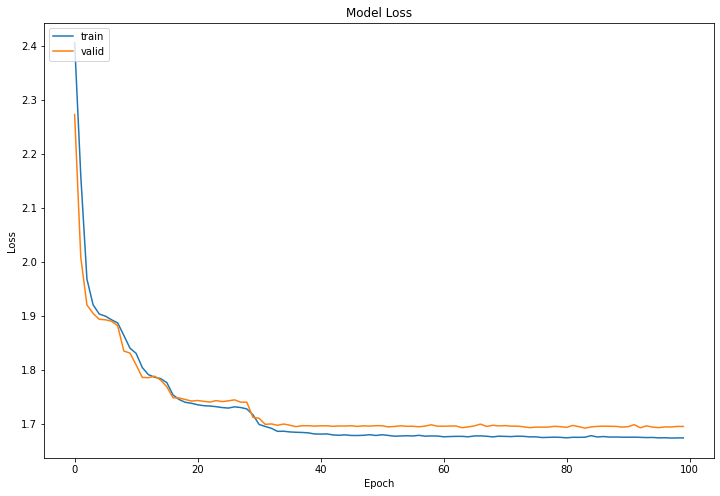

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet152_df["train_loss"])
plt.plot(resnet152_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet176**

**From Scratch**

In [ ]:
resnet176_file_log = files.upload()

Saving results_resnet176_have_dropout_normalize_from_scratch.csv to results_resnet176_have_dropout_normalize_from_scratch (1).csv


In [ ]:
resnet176_df = pd.read_csv(io.BytesIO(resnet176_file_log['results_resnet176_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(resnet176_df, include_index=True, num_rows_per_page=20)

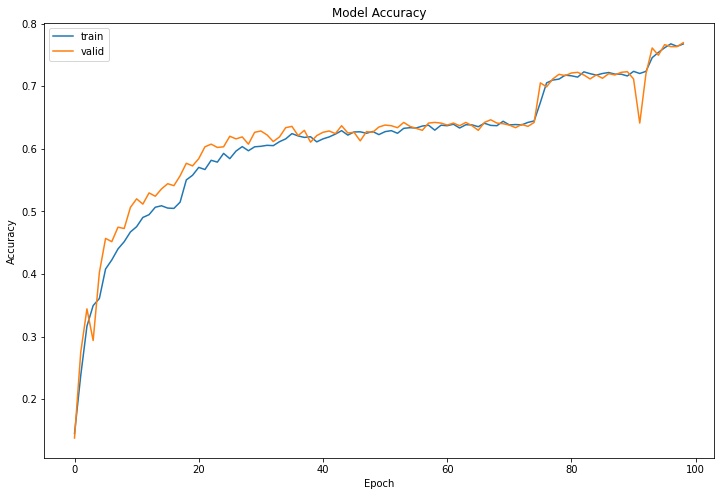

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet176_df["train_accuracy"].iloc[0:99])
plt.plot(resnet176_df["valid_accuracy"].iloc[0:99])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

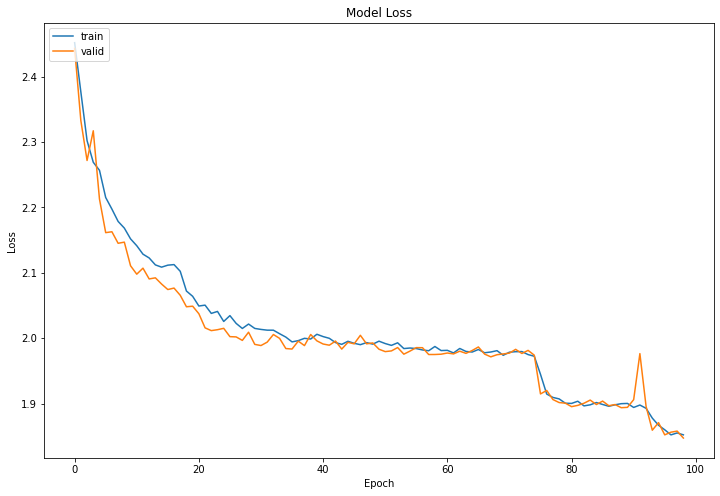

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(resnet176_df["train_loss"].iloc[0:99])
plt.plot(resnet176_df["valid_loss"].iloc[0:99])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**Full Pre-Activation**

In [ ]:
full_pre_resnet176_file_log = files.upload()

Saving results_pre_resnet176_have_dropout_normalize_from_scratch.csv to results_pre_resnet176_have_dropout_normalize_from_scratch (1).csv


In [ ]:
full_pre_resnet176_df = pd.read_csv(io.BytesIO(full_pre_resnet176_file_log['results_pre_resnet176_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(full_pre_resnet176_df, include_index=True, num_rows_per_page=20)

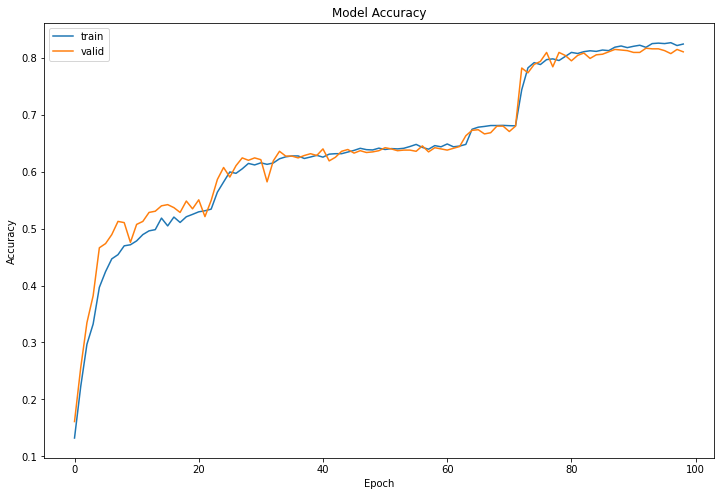

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(full_pre_resnet176_df["train_accuracy"].iloc[0:99])
plt.plot(full_pre_resnet176_df["valid_accuracy"].iloc[0:99])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

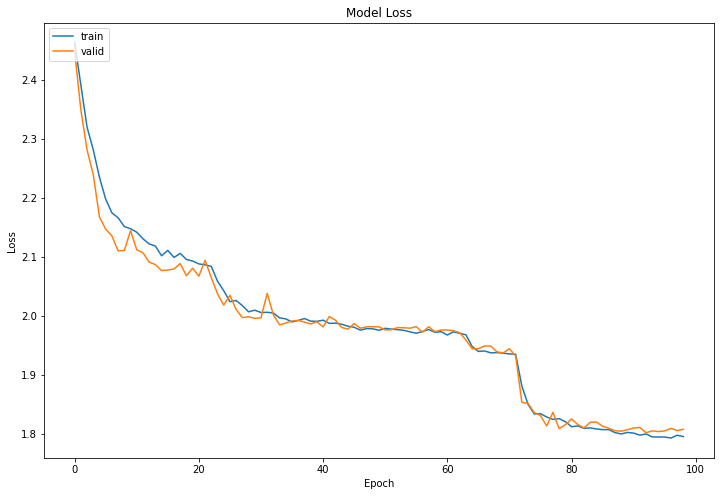

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(full_pre_resnet176_df["train_loss"].iloc[0:99])
plt.plot(full_pre_resnet176_df["valid_loss"].iloc[0:99])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ResNet201**

# **Original**

In [ ]:
original_resnet201_file_log = files.upload()

Saving results_resnet201_have_dropout_normalize_from_scratch.csv to results_resnet201_have_dropout_normalize_from_scratch.csv


In [ ]:
original_resnet201_df = pd.read_csv(io.BytesIO(original_resnet201_file_log['results_resnet201_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(original_resnet201_df, include_index=True, num_rows_per_page=20)

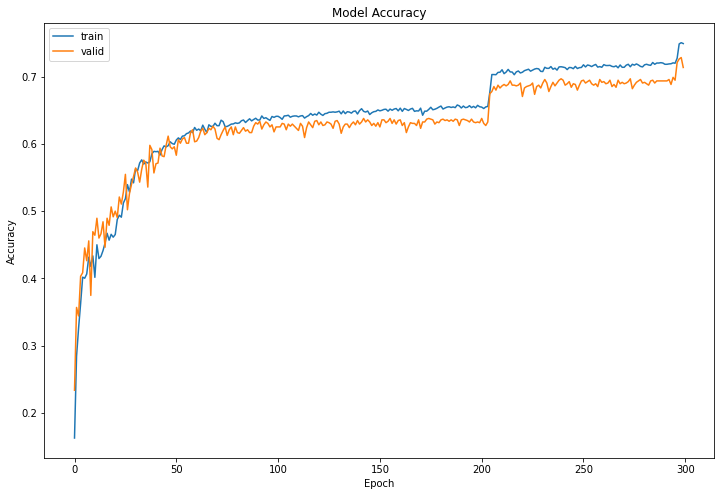

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(original_resnet201_df["train_accuracy"])
plt.plot(original_resnet201_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

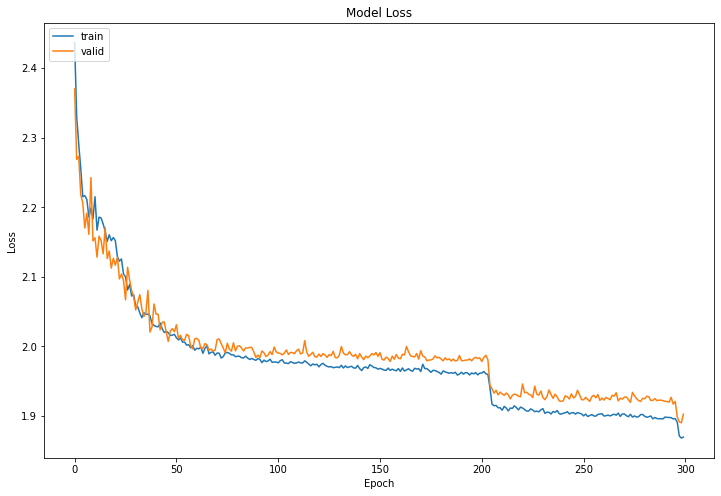

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(original_resnet201_df["train_loss"])
plt.plot(original_resnet201_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **Full-Pre-Activation**

In [ ]:
full_pre_activation_resnet201_file_log = files.upload()

Saving results_pre_resnet201_have_dropout_normalize_from_scratch.csv to results_pre_resnet201_have_dropout_normalize_from_scratch.csv


In [ ]:
full_pre_activation_resnet201_df = pd.read_csv(io.BytesIO(full_pre_activation_resnet201_file_log['results_pre_resnet201_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(full_pre_activation_resnet201_df, include_index=True, num_rows_per_page=20)

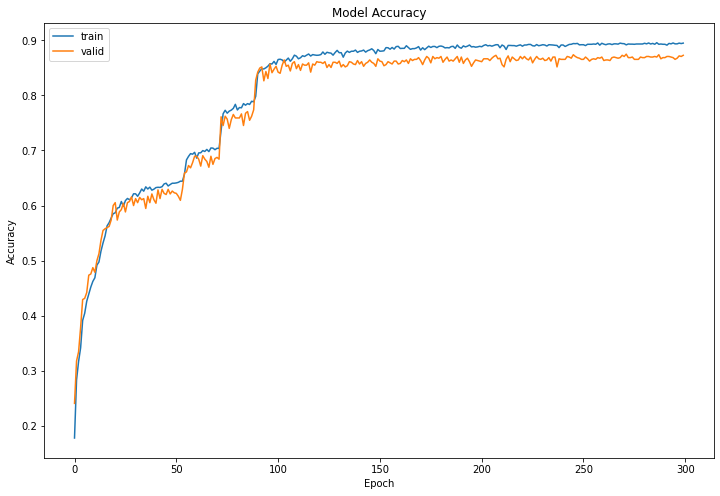

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(full_pre_activation_resnet201_df["train_accuracy"])
plt.plot(full_pre_activation_resnet201_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

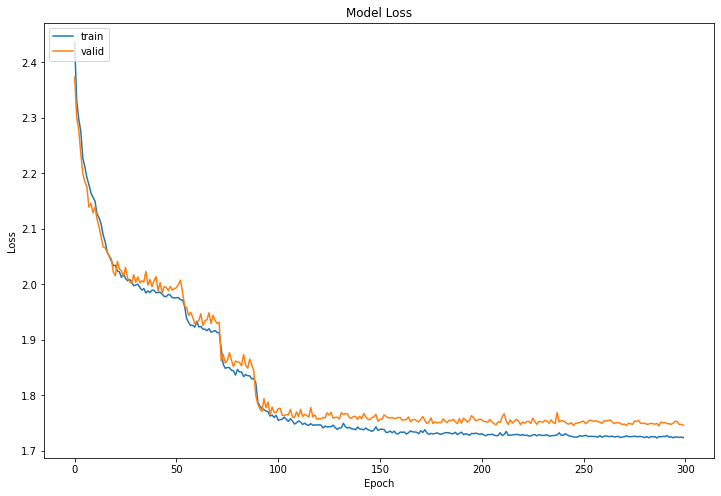

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(full_pre_activation_resnet201_df["train_loss"])
plt.plot(full_pre_activation_resnet201_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ReLU-only pre-activation**

In [ ]:
relu_only_pre_activation_resnet201_file_log = files.upload()

Saving results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv to results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv


In [ ]:
relu_only_pre_activation_resnet201_df = pd.read_csv(io.BytesIO(relu_only_pre_activation_resnet201_file_log['results_reluonlyresnet201_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(relu_only_pre_activation_resnet201_df, include_index=True, num_rows_per_page=20)

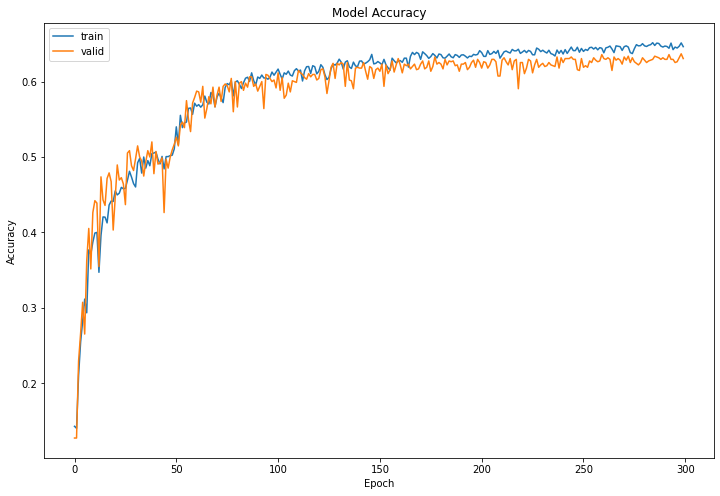

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(relu_only_pre_activation_resnet201_df["train_accuracy"])
plt.plot(relu_only_pre_activation_resnet201_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

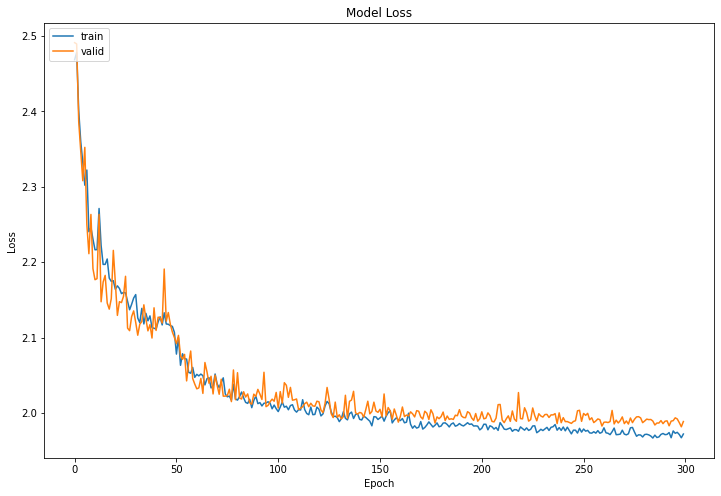

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(relu_only_pre_activation_resnet201_df["train_loss"])
plt.plot(relu_only_pre_activation_resnet201_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **ReLU before addition**

In [ ]:
relu_before_addition_activation_resnet201_file_log = files.upload()

Saving results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv to results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv


In [ ]:
relu_before_addition_activation_resnet201_df = pd.read_csv(io.BytesIO(relu_before_addition_activation_resnet201_file_log['results_relu_before_addition_resNet201_have_dropout_normalize_from_scratch.csv']))
data_table.DataTable(relu_before_addition_activation_resnet201_df, include_index=True, num_rows_per_page=20)

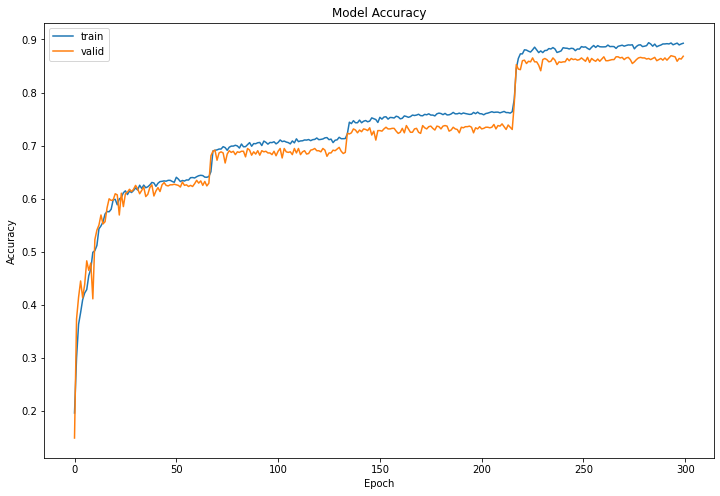

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(relu_before_addition_activation_resnet201_df["train_accuracy"])
plt.plot(relu_before_addition_activation_resnet201_df["valid_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

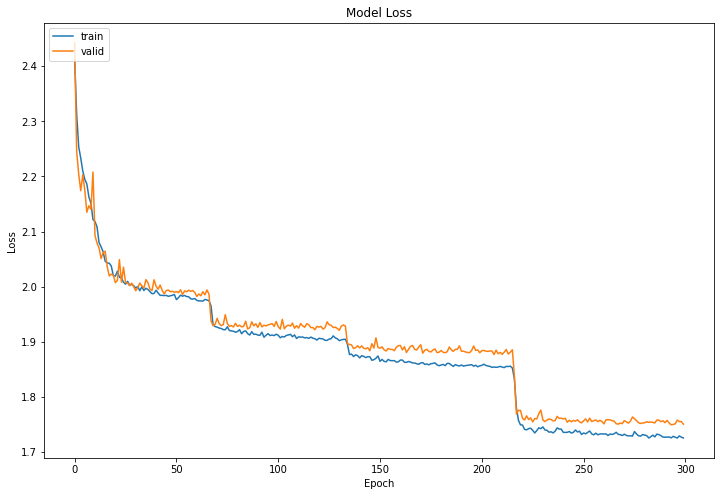

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(relu_before_addition_activation_resnet201_df["train_loss"])
plt.plot(relu_before_addition_activation_resnet201_df["valid_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.show()